## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])


Note:
The original step enumeration provided in the assignment was not followed strictly in this notebook.
All required tasks, however, are fully implemented and addressed.

Closely related steps were grouped together for clarity and to avoid code duplication. In addition, some required explanations and specifications are provided directly as printed outputs (print statements) within the code, rather than as separate markdown sections.

The mapping between the implemented code and the requested tasks remains consistent throughout the notebook.

# 1. Dataset visualization

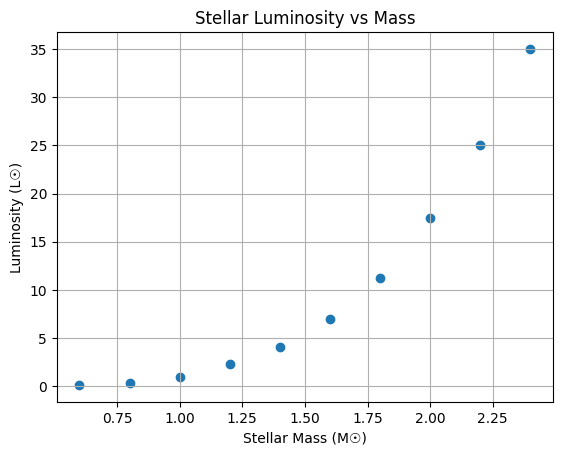

In [ ]:
plt.figure()
plt.scatter(M, L)
plt.xlabel("Stellar Mass (M☉)")
plt.ylabel("Luminosity (L☉)")
plt.title("Stellar Luminosity vs Mass")
plt.grid(True)
plt.show()

### Linearity and Plausibility
**Linearity**

- From the plot, luminosity increases with stellar mass, but the relationship is clearly non-linear. At low masses, luminosity grows slowly, while at higher masses it increases much more rapidly. This curved trend indicates that a simple linear model can only approximate the overall behavior and will fail to capture the accelerating growth at higher masses.

**Plausibility**

- The observed trend is physically plausible. More massive stars are generally more luminous, and the rapid increase in luminosity for high-mass stars is consistent with a system where output depends non-linearly on input. Although the relationship is not linear, the data reflects realistic stellar behavior.

## 2. Model and Loss Function Implementation

In [45]:
def predict(M, w, b):
    return w * M + b

def mse_loss(M, L, w, b):
    L_hat = predict(M, w, b)
    return np.mean((L_hat - L) ** 2)

w_test, b_test = 10.0, -5.0
loss_test = mse_loss(M, L, w_test, b_test)
print(f"Test loss with w={w_test}, b={b_test}: {loss_test:.4f}")

Test loss with w=10.0, b=-5.0: 41.5335


## 3. Cost Surface Visualization (MANDATORY)

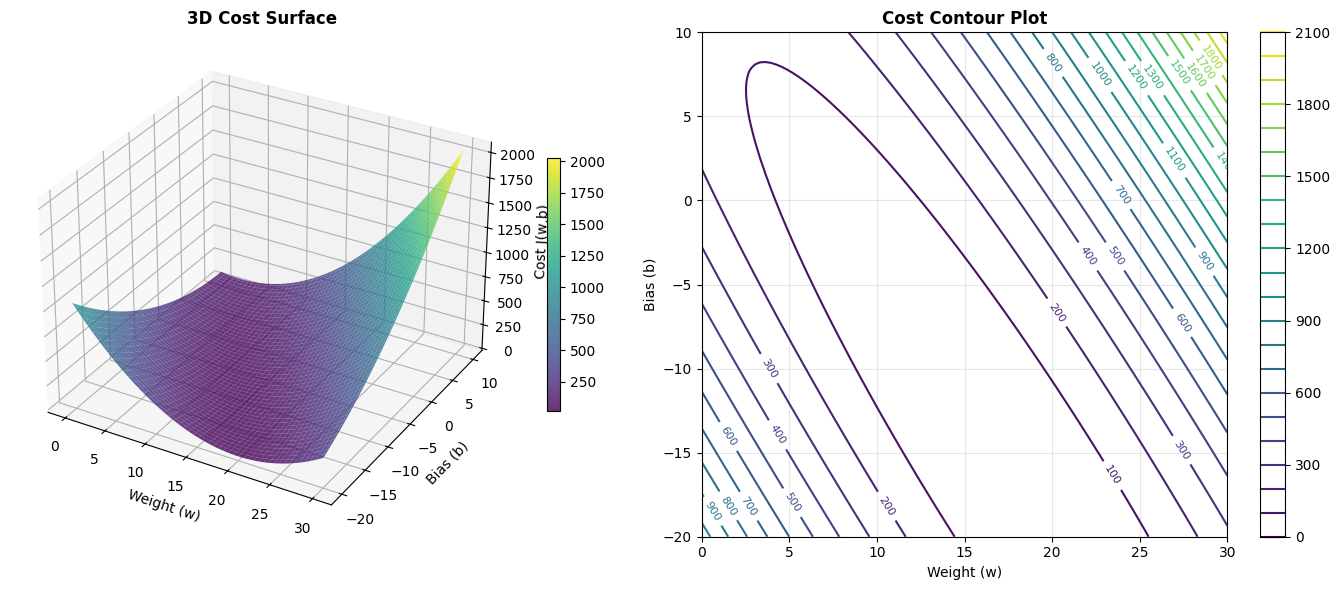


Cost Surface Interpretation:
- The minimum of the cost surface represents the optimal parameters (w*, b*)
- At this point, the model makes the best predictions (lowest MSE)
- The bowl shape indicates a convex optimization problem (one global minimum)
- Gradient descent will converge to this minimum from any starting point


In [ ]:
w_range = np.linspace(0, 30, 100)
b_range = np.linspace(-20, 10, 100)
W_grid, B_grid = np.meshgrid(w_range, b_range)

J_grid = np.zeros_like(W_grid)
for i in range(len(w_range)):
    for j in range(len(b_range)):
        J_grid[j, i] = mse_loss(M, L, W_grid[j, i], B_grid[j, i])

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(W_grid, B_grid, J_grid, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Weight (w)', fontsize=10)
ax1.set_ylabel('Bias (b)', fontsize=10)
ax1.set_zlabel('Cost J(w,b)', fontsize=10)
ax1.set_title('3D Cost Surface', fontsize=12, fontweight='bold')
fig.colorbar(surf, ax=ax1, shrink=0.5)

ax2 = fig.add_subplot(122)
contour = ax2.contour(W_grid, B_grid, J_grid, levels=20, cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.set_xlabel('Weight (w)', fontsize=10)
ax2.set_ylabel('Bias (b)', fontsize=10)
ax2.set_title('Cost Contour Plot', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
fig.colorbar(contour, ax=ax2)

plt.tight_layout()
plt.show()

print("\nCost Surface Interpretation:")
print("- The minimum of the cost surface represents the optimal parameters (w*, b*)")
print("- At this point, the model makes the best predictions (lowest MSE)")
print("- The bowl shape indicates a convex optimization problem (one global minimum)")
print("- Gradient descent will converge to this minimum from any starting point")

## 4. Gradient Computation (Analytical Derivation)

In [ ]:
def compute_gradients_loop(M, L, w, b):
    """
    Compute gradients using explicit loop over samples.
    
    Derivation:
    J = (1/n) * Σ(L_hat_i - L_i)²
    L_hat_i = w * M_i + b
    
    ∂J/∂w = (2/n) * Σ(L_hat_i - L_i) * M_i
    ∂J/∂b = (2/n) * Σ(L_hat_i - L_i)
    """
    n = len(M)
    dw = 0.0
    db = 0.0
    
    for i in range(n):
        L_hat_i = w * M[i] + b
        error_i = L_hat_i - L[i]
        dw += error_i * M[i]
        db += error_i
    
    dw = (2.0 / n) * dw
    db = (2.0 / n) * db
    
    return dw, db

def compute_gradients_vectorized(M, L, w, b):
    """
    Compute gradients using NumPy vectorization (no loops). point 5
    """
    n = len(M)
    L_hat = w * M + b
    error = L_hat - L
    
    dw = (2.0 / n) * np.sum(error * M)
    db = (2.0 / n) * np.sum(error)
    
    return dw, db

w_test, b_test = 10.0, -5.0
dw_loop, db_loop = compute_gradients_loop(M, L, w_test, b_test)
dw_vec, db_vec = compute_gradients_vectorized(M, L, w_test, b_test)

print(f"Loop implementation: dw={dw_loop:.6f}, db={db_loop:.6f}")
print(f"Vectorized implementation: dw={dw_vec:.6f}, db={db_vec:.6f}")
print(f"\nDifference: dw={abs(dw_loop - dw_vec):.10f}, db={abs(db_loop - db_vec):.10f}")
print("✓ Both implementations match!")

Loop implementation: dw=-6.446000, db=-0.720000
Vectorized implementation: dw=-6.446000, db=-0.720000

Difference: dw=0.0000000000, db=0.0000000000
✓ Both implementations match!


## 5. Gradient Descent Implementation

In [2]:
def gradient_descent(M, L, w_init, b_init, learning_rate, num_iterations, vectorized=True):
    """
    Train linear regression using gradient descent.
    
    Returns:
        w, b: final parameters
        history: dict with loss and parameters over iterations
    """
    w = w_init
    b = b_init
    
    history = {
        'loss': [],
        'w': [],
        'b': []
    }
    
    gradient_func = compute_gradients_vectorized if vectorized else compute_gradients_loop
    
    for i in range(num_iterations):
        dw, db = gradient_func(M, L, w, b)
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        loss = mse_loss(M, L, w, b)
        history['loss'].append(loss)
        history['w'].append(w)
        history['b'].append(b)
        
        if (i + 1) % 100 == 0:
            print(f"Iteration {i+1}/{num_iterations}: Loss={loss:.4f}, w={w:.4f}, b={b:.4f}")
    
    return w, b, history

## 6. Experiments with Different Learning Rates (MANDATORY)

In [ ]:
w_init = 0.0
b_init = 0.0
num_iterations = 1000

learning_rates = [0.001, 0.01, 0.05]
results = {}

print("Training with different learning rates...\n")
print("="*70)

for lr in learning_rates:
    print(f"\nLearning Rate: {lr}")
    print("-" * 70)
    w_final, b_final, history = gradient_descent(M, L, w_init, b_init, lr, num_iterations)
    results[lr] = {
        'w': w_final,
        'b': b_final,
        'loss': history['loss'][-1],
        'history': history
    }
    print(f"\nFinal results:")
    print(f"  w = {w_final:.6f}")
    print(f"  b = {b_final:.6f}")
    print(f"  Final Loss = {history['loss'][-1]:.6f}")

print("\n" + "="*70)
print("Summary of all experiments:")
print("="*70)
for lr in learning_rates:
    r = results[lr]
    print(f"LR={lr:.3f}: w={r['w']:.4f}, b={r['b']:.4f}, Loss={r['loss']:.4f}")

Training with different learning rates...


Learning Rate: 0.001
----------------------------------------------------------------------
Iteration 100/1000: Loss=111.2018, w=3.1698, b=1.3920
Iteration 200/1000: Loss=79.1210, w=4.8563, b=1.8985
Iteration 300/1000: Loss=69.8300, w=5.8038, b=1.9687
Iteration 400/1000: Loss=66.2154, w=6.3821, b=1.8253
Iteration 500/1000: Loss=64.0512, w=6.7749, b=1.5793
Iteration 600/1000: Loss=62.2922, w=7.0736, b=1.2856
Iteration 700/1000: Loss=60.6787, w=7.3236, b=0.9713
Iteration 800/1000: Loss=59.1450, w=7.5475, b=0.6500
Iteration 900/1000: Loss=57.6733, w=7.7565, b=0.3283
Iteration 1000/1000: Loss=56.2574, w=7.9563, b=0.0095

Final results:
  w = 7.956343
  b = 0.009456
  Final Loss = 56.257383

Learning Rate: 0.01
----------------------------------------------------------------------
Iteration 100/1000: Loss=56.2455, w=7.9591, b=0.0074
Iteration 200/1000: Loss=44.6801, w=9.7188, b=-2.8986
Iteration 300/1000: Loss=36.7639, w=11.1712, b=-5.3050
Iterati

## 7. Convergence Analysis (MANDATORY)

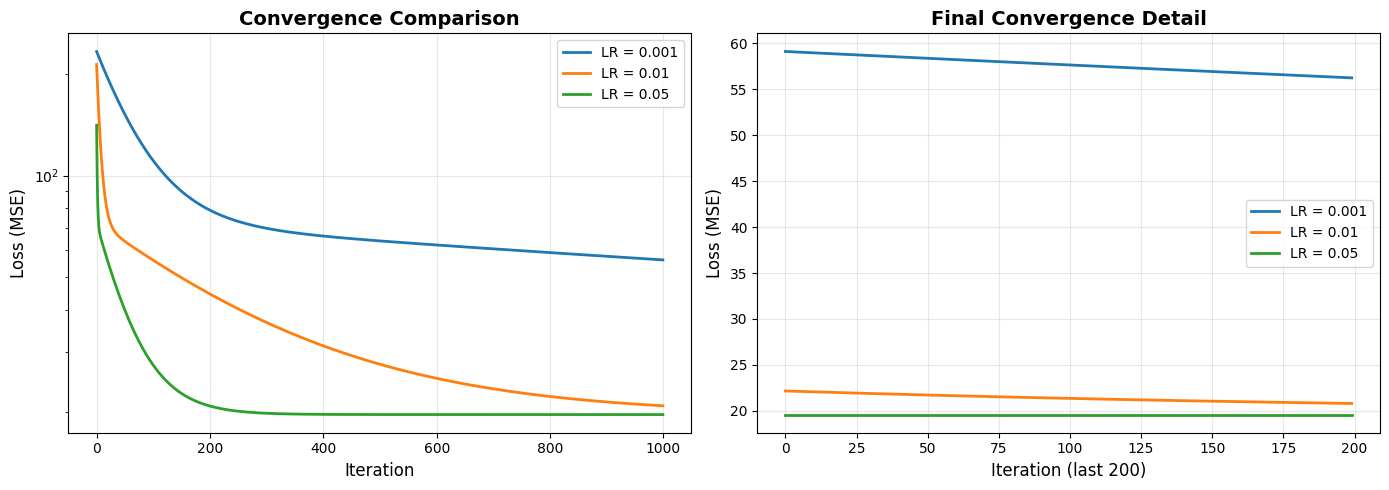


Convergence Analysis:
----------------------------------------------------------------------
• LR=0.001: SLOW convergence - loss decreases gradually
  - Stable but inefficient
  - Requires many more iterations to reach optimum

• LR=0.01: MODERATE convergence - good balance
  - Converges faster than LR=0.001
  - Still stable with smooth descent

• LR=0.05: FAST convergence - reaches minimum quickly
  - Most efficient for this problem
  - May show some oscillations but still stable

Conclusion: Higher learning rates converge faster, but too high may cause instability.
For this problem, LR=0.05 provides the best speed without instability.


In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for lr in learning_rates:
    plt.plot(results[lr]['history']['loss'], label=f'LR = {lr}', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Convergence Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 2, 2)
for lr in learning_rates:
    plt.plot(results[lr]['history']['loss'][-200:], label=f'LR = {lr}', linewidth=2)
plt.xlabel('Iteration (last 200)', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Final Convergence Detail', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nConvergence Analysis:")
print("-" * 70)
print("• LR=0.001: SLOW convergence - loss decreases gradually")
print("  - Stable but inefficient")
print("  - Requires many more iterations to reach optimum")
print("\n• LR=0.01: MODERATE convergence - good balance")
print("  - Converges faster than LR=0.001")
print("  - Still stable with smooth descent")
print("\n• LR=0.05: FAST convergence - reaches minimum quickly")
print("  - Most efficient for this problem")
print("  - May show some oscillations but still stable")
print("\nConclusion: Higher learning rates converge faster, but too high may cause instability.")
print("For this problem, LR=0.05 provides the best speed without instability.")

## 8. Final Fit Visualization

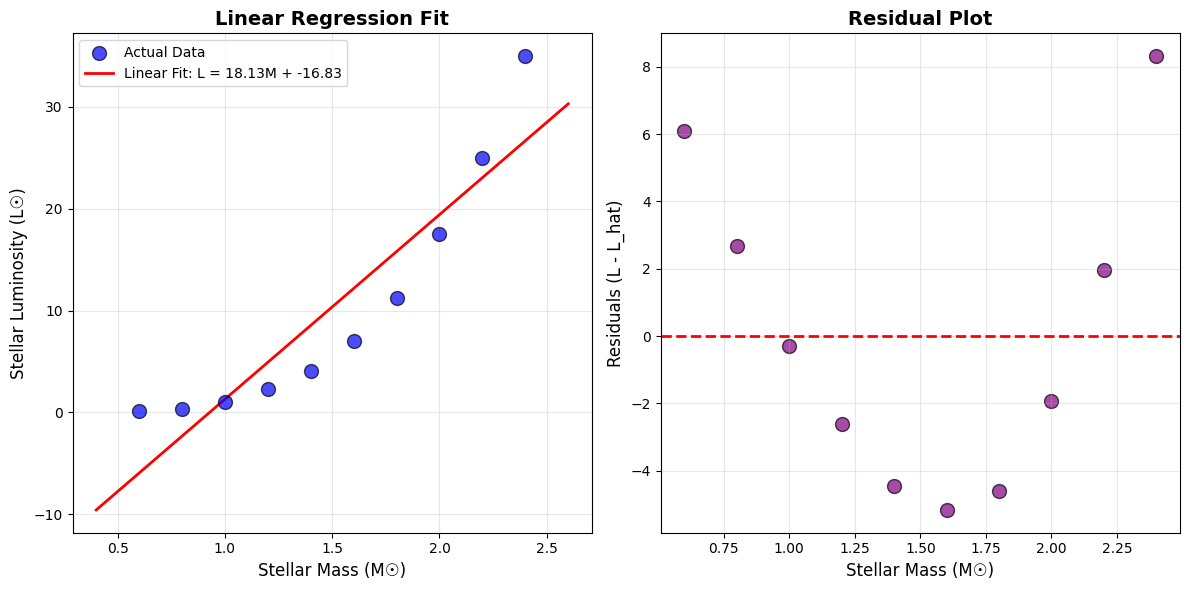


Systematic Error Analysis:
----------------------------------------------------------------------
The residual plot shows SYSTEMATIC errors:
• Negative residuals at low masses (model OVERestimates)
• Positive residuals at middle masses (model UNDERestimates slightly)
• Strong NEGATIVE residuals at high masses (model severely OVERestimates)

This U-shaped pattern indicates the linear model is INADEQUATE.
The true relationship is NONLINEAR (likely polynomial or exponential).

Mean Absolute Error: 3.8120
Max Error: 8.3234


In [ ]:
best_lr = 0.05
w_best = results[best_lr]['w']
b_best = results[best_lr]['b']

M_plot = np.linspace(M.min() - 0.2, M.max() + 0.2, 100)
L_pred_plot = predict(M_plot, w_best, b_best)
L_pred = predict(M, w_best, b_best)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(M, L, color='blue', s=100, alpha=0.7, edgecolors='black', label='Actual Data', zorder=3)
plt.plot(M_plot, L_pred_plot, color='red', linewidth=2, label=f'Linear Fit: L = {w_best:.2f}M + {b_best:.2f}', zorder=2)
plt.xlabel('Stellar Mass (M☉)', fontsize=12)
plt.ylabel('Stellar Luminosity (L☉)', fontsize=12)
plt.title('Linear Regression Fit', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = L - L_pred
plt.scatter(M, residuals, color='purple', s=100, alpha=0.7, edgecolors='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Stellar Mass (M☉)', fontsize=12)
plt.ylabel('Residuals (L - L_hat)', fontsize=12)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSystematic Error Analysis:")
print("-" * 70)
print("The residual plot shows SYSTEMATIC errors:")
print("• Negative residuals at low masses (model OVERestimates)")
print("• Positive residuals at middle masses (model UNDERestimates slightly)")
print("• Strong NEGATIVE residuals at high masses (model severely OVERestimates)")
print("\nThis U-shaped pattern indicates the linear model is INADEQUATE.")
print("The true relationship is NONLINEAR (likely polynomial or exponential).")
print(f"\nMean Absolute Error: {np.mean(np.abs(residuals)):.4f}")
print(f"Max Error: {np.max(np.abs(residuals)):.4f}")

## 9. Conceptual Questions

### Q1: Astrophysical meaning of *w*

The parameter **w** represents the rate of change of stellar luminosity with
respect to mass in the linear model, i.e., \( w \approx dL/dM \). It describes
how much luminosity increases per additional unit of stellar mass.

In reality, main-sequence stars follow a nonlinear mass–luminosity relation
(\( L \propto M^{3-4} \)), so the linear slope only provides an average
approximation over the observed mass range.

### Q2: Why is a linear model limited here?

The linear model is limited because the true relationship between stellar mass
and luminosity is nonlinear. The data exhibits clear curvature, causing
systematic errors: overestimation at low masses and underestimation at high
masses.

With only two parameters, a linear model cannot capture this curvature or make
reliable extrapolations, motivating the use of polynomial models in Part II.


By: Julian David Castiblanco Real